In [32]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gc
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras import optimizers
from tensorflow.keras import layers,Model
from sklearn.model_selection import KFold,cross_validate

from sklearn import ensemble
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [5]:
def PrintAll(x):
    pd.set_option('display.max_rows',len(x))
    print(x)
    pd.set_option('display.max_rows',10)

In [6]:
# import data
trainData = pd.read_csv('train.csv',header = 0)
testData = pd.read_csv('test.csv',header = 0)
pId = testData['PassengerId']

print("Train data number : {}".format(trainData.shape[0]))
print("Test data number : {}".format(testData.shape[0])) 

Train data number : 891
Test data number : 418


In [7]:
# Check missing data
def MissingData(data):
    total = data.isnull().count()
    count = data.isnull().sum()
    missingData = pd.DataFrame({'percent(%)':count/total * 100})
    PrintAll(missingData)

In [8]:
MissingData(trainData)
MissingData(testData)

             percent(%)
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age           19.865320
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin         77.104377
Embarked       0.224467
             percent(%)
PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age           20.574163
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.239234
Cabin         78.229665
Embarked       0.000000


In [9]:
# Has Cabin
trainData['HasCabin'] = trainData['Cabin'].apply(lambda x:0 if type(x) == float else 1)
testData['HasCabin'] = testData['Cabin'].apply(lambda x:0 if type(x) == float else 1)

trainData.head()
testData.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


In [10]:
# Deal with missing values
def nan_padding(data, columns):
    for c in columns:
        data[c].fillna(data[c].median(), inplace = True)
    return data

columns = ["Age","SibSp", "Parch","Fare"]
trainData = nan_padding(trainData, columns)
testData = nan_padding(testData, columns)

trainData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [11]:
# Filled Embark 
trainData['Embarked'].fillna(trainData['Embarked'].mode()[0],inplace = True)
testData['Embarked'].fillna(testData['Embarked'].mode()[0],inplace = True)

In [12]:
# Check missing test data
MissingData(trainData)
MissingData(testData)

             percent(%)
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin         77.104377
Embarked       0.000000
HasCabin       0.000000
             percent(%)
PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin         78.229665
Embarked       0.000000
HasCabin       0.000000


In [13]:
# Print all title
def GetTitle(name):
    title = re.search(" ([A-Za-z]+)\. ",name)
    if title:        
        return title.group(1)
    else:
        return 0
# Add title
def NameToTitle(data):    
    data['Title'] = data['Title'].replace(['Mile','Ms','Lady'],'Miss')    
    data['Title'] = data['Title'].replace('Mme','Mrs')    
    data['Title'] = data["Title"].replace(['Rev','Dr','Col','Mlle','Major','Dona','Don','Countess','Capt','Sir','Jonkheer'],'Rare')    
    return data


trainData["Title"] = trainData['Name'].apply(GetTitle)
testData["Title"] =  testData['Name'].apply(GetTitle)

trainData = NameToTitle(trainData)
testData = NameToTitle(testData)

title = pd.concat([trainData['Title'],testData['Title']]).value_counts()
PrintAll(title)

Mr        757
Miss      263
Mrs       198
Master     61
Rare       30
Name: Title, dtype: int64


In [14]:
def ConvertSex(data):
    le = LabelEncoder()
    le.fit(['male','female'])
    data['Sex'] = le.transform(data['Sex'])
    return
ConvertSex(trainData)
ConvertSex(testData)

trainData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,1,Mrs
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0,Mr


In [15]:
# Family size
trainData['FamilySize'] = trainData['SibSp'] + trainData['Parch'] + 1
testData['FamilySize'] = testData['SibSp'] + testData['Parch'] + 1

trainData['IsAlone'] = trainData['FamilySize'].apply(lambda x: 1 if x==1 else 0)
testData['IsAlone'] = testData['FamilySize'].apply(lambda x: 1 if x==1 else 0)


trainData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,Title,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,1,Mrs,2,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0,Mr,1,1


In [16]:
# Change age
def ConvertAge(age):
    if age <=12 :
        return "Child"        
    elif age<=18:
        return "Teen"
    elif age<=60:
        return "Adult"
    else : return "Elder"
trainData['AgeRange'] = trainData['Age'].apply(ConvertAge)
testData['AgeRange'] = testData['Age'].apply(ConvertAge)
trainData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,Title,FamilySize,IsAlone,AgeRange
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr,2,0,Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs,2,0,Adult
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss,1,1,Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,1,Mrs,2,0,Adult
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0,Mr,1,1,Adult


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,Title,FamilySize,IsAlone,AgeRange,FareRange
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr,2,0,Adult,LowFare
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs,2,0,Adult,HighFare
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss,1,1,Adult,MedianFare
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,1,Mrs,2,0,Adult,HighFare
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0,Mr,1,1,Adult,MedianFare


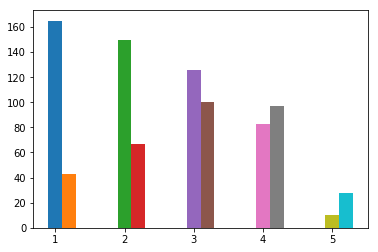

In [17]:
j = 0
k = 0
for i in [7.91,14.45,31,120,float('inf')]:
    k+=1
    plt.bar(k,((trainData['Fare']<i) & (trainData['Fare']>j) & (trainData['Survived']==0)).sum(),0.2)
    plt.bar(k+0.2,((trainData['Fare']<i) & (trainData['Fare']>j) & (trainData['Survived']==1)).sum(),0.2)
    j = i

# Change fare
def ConvertFare(data):
    data['FareRange'] = pd.cut(data['Fare'],
                                bins = [0,7.91,14.45,31,120,float("inf")],
                               labels = ['LowFare', "MedianFare","AverageFare","HighFare","SuperFare"])
    return data
trainData = ConvertFare(trainData)
testData = ConvertFare(testData)
trainData.head()

In [18]:
def DummyData(data, columns):
    for c in columns:
        data = pd.concat([data,pd.get_dummies(data[c],prefix = c)],axis = 1)
        data = data.drop(c,axis = 1)
    return data

columns = ['Pclass','Embarked','Title','FareRange',"AgeRange"]
trainData = DummyData(trainData,columns)
testData = DummyData(testData,columns)

trainData.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Title_Rare,FareRange_LowFare,FareRange_MedianFare,FareRange_AverageFare,FareRange_HighFare,FareRange_SuperFare,AgeRange_Adult,AgeRange_Child,AgeRange_Elder,AgeRange_Teen
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,...,0,1,0,0,0,0,1,0,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,...,0,0,0,0,1,0,1,0,0,0
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,0,0,1,0,0,0,1,0,0,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,...,0,0,0,0,1,0,1,0,0,0
4,5,0,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,...,0,0,1,0,0,0,1,0,0,0


In [19]:
def NormalizeData(data,columns):
    scaler = MinMaxScaler()
    for c in columns:
        data[c] = scaler.fit_transform(data[c].values.reshape(-1,1))
    return data


#columns = ['Fare','Age']
#trainData = NormalizeData(trainData,columns)
#testData = NormalizeData(testData,columns)

#trainData.head()

In [20]:
# Drop useless data
def DropColumn(data, columns):    
    return data.drop(columns,axis = 1)


columns = ['PassengerId','Name',"Ticket", "Cabin","Age","Fare"]
trainData = DropColumn(trainData,columns)
testData = DropColumn(testData,columns)

trainData.head()

,Survived,Sex,SibSp,Parch,HasCabin,FamilySize,IsAlone,Pclass_1,Pclass_2,Pclass_3,...,Title_Rare,FareRange_LowFare,FareRange_MedianFare,FareRange_AverageFare,FareRange_HighFare,FareRange_SuperFare,AgeRange_Adult,AgeRange_Child,AgeRange_Elder,AgeRange_Teen
0,0,1,1,0,0,2,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
1,1,0,1,0,1,2,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
2,1,0,0,0,0,1,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0
3,1,0,1,0,1,2,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
4,0,1,0,0,0,1,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0


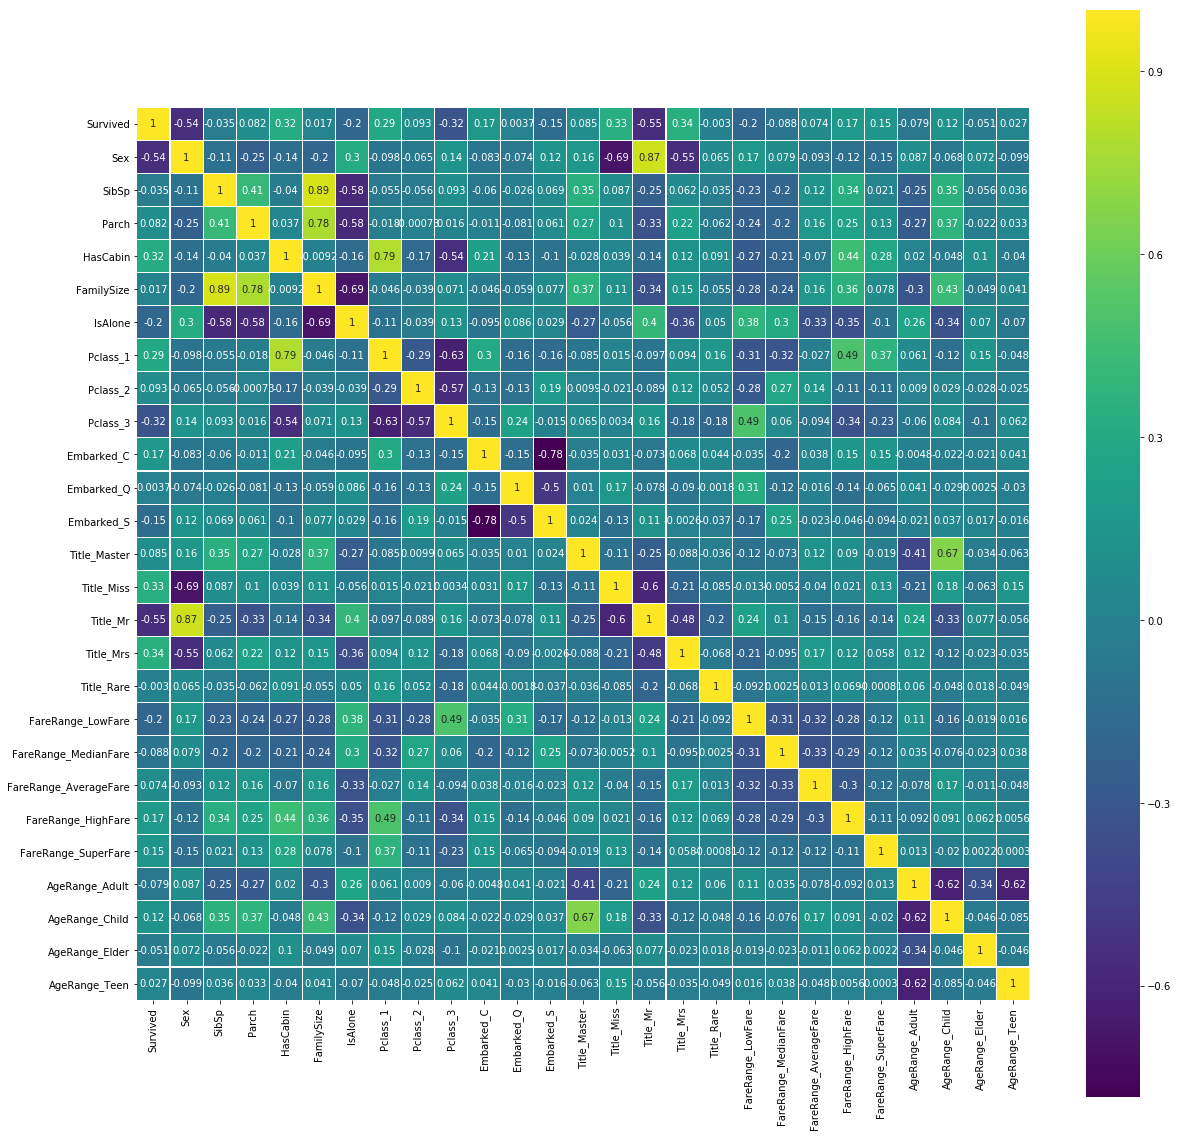

In [21]:
# Visualize co-relation
colormap = plt.cm.viridis
plt.figure(figsize=(20,20))
#plt.title("Correlation of Features")
sns.heatmap(trainData.astype(float).corr(),linewidths=0.1,vmax=1.0,square = True, cmap=colormap,linecolor='white',annot=True)

In [22]:
# Drop data with low co-relation
columns = ['Title_Rare','Embarked_C']
trainData = DropColumn(trainData,columns)
testData = DropColumn(testData,columns)


In [23]:
trainData.head()

,Survived,Sex,SibSp,Parch,HasCabin,FamilySize,IsAlone,Pclass_1,Pclass_2,Pclass_3,...,Title_Mrs,FareRange_LowFare,FareRange_MedianFare,FareRange_AverageFare,FareRange_HighFare,FareRange_SuperFare,AgeRange_Adult,AgeRange_Child,AgeRange_Elder,AgeRange_Teen
0,0,1,1,0,0,2,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
1,1,0,1,0,1,2,0,1,0,0,...,1,0,0,0,1,0,1,0,0,0
2,1,0,0,0,0,1,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0
3,1,0,1,0,1,2,0,1,0,0,...,1,0,0,0,1,0,1,0,0,0
4,0,1,0,0,0,1,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0


In [24]:
testData.head()

,Sex,SibSp,Parch,HasCabin,FamilySize,IsAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_Q,...,Title_Mrs,FareRange_LowFare,FareRange_MedianFare,FareRange_AverageFare,FareRange_HighFare,FareRange_SuperFare,AgeRange_Adult,AgeRange_Child,AgeRange_Elder,AgeRange_Teen
0,1,0,0,0,1,1,0,0,1,1,...,0,1,0,0,0,0,1,0,0,0
1,0,1,0,0,2,0,0,0,1,0,...,1,1,0,0,0,0,1,0,0,0
2,1,0,0,0,1,1,0,1,0,1,...,0,0,1,0,0,0,0,0,1,0
3,1,0,0,0,1,1,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
4,0,1,1,0,3,0,0,0,1,0,...,1,0,1,0,0,0,1,0,0,0


In [25]:
trainX = trainData.iloc[:,1:].to_numpy()
trainY = trainData.loc[:,'Survived'].to_numpy()
testX = testData.iloc[:,:].to_numpy()

In [ ]:
# Deep Learning

In [ ]:
# Check point
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = "./checkpoint.ckpt" , 
                                                 save_weights_only = True,
                                                 save_best_only = True,
                                                 peroid=5, 
                                                 verbose = 1)

In [ ]:
def CreateModel():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units = 4096, 
                              activation = 'relu', 
                              input_shape=(trainX.shape[1],), 
                              kernel_regularizer = tf.keras.regularizers.l2(0.001)),  
        tf.keras.layers.Dense(units = 4096, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.001)),        
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.Dense(units = 4096, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.001)), 
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.Dense(units = 4096, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.001)),                
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    return model

In [ ]:
model = CreateModel()
model.summary()

In [ ]:
# evaluate
kf = KFold(n_splits=10, shuffle = True)
fold_accuracy = []
fold_loss = []
i = 1
for train_index, test_index in kf.split(trainData):        
    model = CreateModel()
    model.compile(loss = 'binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(lr = 0.0001),
             metrics = ['accuracy'])
    history = model.fit(  x = trainX[train_index],
                          y = trainY[train_index],
                          epochs = 500,
                          verbose = 2,
                          validation_data = (trainX[test_index],trainY[test_index]),
                          callbacks=[cp_callback],
                     )
    # evaluate
    test_loss, test_acc = model.evaluate(trainX[test_index],trainY[test_index],verbose = 0)    
    print('Fold: {}, test accuracy: {}, test loss: {}'.format(i,test_acc,test_loss))
    fold_accuracy.append(test_acc)
    fold_loss.append(test_loss)
    # plot lose
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(122)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    i+=1
#model.load_weights('./checkpoint.ckpt')          
avg_acc = sum(fold_accuracy)/len(fold_accuracy)
avg_loss = sum(fold_loss)/len(fold_loss)
print('avg accuracy: {}, avg loss: {}'.format(avg_acc,avg_loss))

In [ ]:
# Training
model = CreateModel()
model.compile(loss = 'binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(lr = 0.00005),
             metrics = ['accuracy'])
history = model.fit(  x = trainX,
                      y = trainY,
                      epochs = 1000,
                      verbose = 2,
)        

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')

# plot accuracy
plt.subplot(122)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')


In [ ]:
# predictions
predictions = model.predict_classes(testX).reshape(len(testX))
# write csv file
submission =pd.DataFrame({'PassengerId':pId,'Survived':predictions})
submission.to_csv('Titanic Predictions DL.csv',index = False)

In [ ]:
# Random forest

In [57]:
kf = KFold(n_splits=10, shuffle = True)
fold_accuracy = []
i = 1
for train_index, test_index in kf.split(trainData): 
    forest = RandomForestClassifier(n_estimators = 1000,max_depth = 5,min_samples_split = 10)
    forest.fit(trainX[train_index],trainY[train_index])
    predict = forest.predict(trainX[test_index])
    #confusion_matrix
    conf_mat = metrics.confusion_matrix(trainY[test_index],predict)
    print(classification_report(predict,trainY[test_index]))
    test_acc = accuracy_score(predict,trainY[test_index])
    print(test_acc)
    fold_accuracy.append(test_acc)
    
avg_acc = sum(fold_accuracy)/len(fold_accuracy)
print('avg accuracy: {}'.format(avg_acc))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90        58
           1       0.83      0.78      0.81        32

    accuracy                           0.87        90
   macro avg       0.86      0.85      0.85        90
weighted avg       0.87      0.87      0.87        90

0.8666666666666667
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        59
           1       0.73      0.80      0.76        30

    accuracy                           0.83        89
   macro avg       0.81      0.82      0.82        89
weighted avg       0.84      0.83      0.83        89

0.8314606741573034
              precision    recall  f1-score   support

           0       0.84      0.76      0.80        55
           1       0.67      0.76      0.71        34

    accuracy                           0.76        89
   macro avg       0.75      0.76      0.76        89
weighted avg       0.77      0.76   

In [58]:
forest = RandomForestClassifier(n_estimators = 1000,max_depth = 5,min_samples_split = 10)
forest.fit(trainX,trainY)
print("Train accuracy : {}".format(forest.score(trainX,trainY)))

Train accuracy : 0.8361391694725028


In [59]:
#prediction
predictions = forest.predict(testX)
# write csv file
submission =pd.DataFrame({'PassengerId':pId,'Survived':predictions})
submission.to_csv('Titanic Predictions RF.csv',index = False)